### Simulation SGD for titanic data

In [2]:
from datetime import datetime
from csv import DictReader
from math import exp, log, sqrt
import numpy as np
import mmh3
import time
from spooky import hash128, hash64, hash32

from sklearn.metrics import roc_curve, auc
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

###### Parameters

In [3]:
D = 2 ** 20
rand_seed = 1004

num_poly = 10
xxi, wwi = np.polynomial.hermite.hermgauss(num_poly)

In [4]:
class DataSize:
    def __init__(self
                 , num_metric_check_point
                 , num_status_check_point
                 , num_train_data_start
                 , num_train_data_size
                 , num_test_data_start
                 , num_test_data_size):
        
        self.num_metric_check_point = num_metric_check_point
        self.num_status_check_point = num_status_check_point
        
        self.num_train_data_start = num_train_data_start
        self.num_train_data_end = self.num_train_data_start + num_train_data_size - 1 # fixed
        
        self.num_test_data_start = num_test_data_start
        self.num_test_data_end = self.num_test_data_start + num_test_data_size - 1 # fixed
        
    def display(self):
        print("num_metric_check_point: %s" %(self.num_metric_check_point))
        print("num_status_check_point: %s" %(self.num_status_check_point))
        print("num_train_data_start  : %s" %(self.num_train_data_start))
        print("num_train_data_end    : %s" %(self.num_train_data_end))
        print("num_train_data_size   : %s" %(self.num_train_data_end - self.num_train_data_start + 1))
        print("num_test_data_start   : %s" %(self.num_test_data_start))
        print("num_test_data_end     : %s" %(self.num_test_data_end))
        print("num_test_data_size    : %s" %(self.num_test_data_end - self.num_test_data_start + 1))

In [5]:
class FileInfo:
    def __init__(self
                , _file_path
                , _f_having_header
                , _l_header_names
                , _seperator
                , _l_skip_columns
                , _ylab):
        self.file_path = _file_path
        self.f_having_header = _f_having_header
        self.l_header_names = _l_header_names
        self.seperator = _seperator
        self.l_skip_columns = _l_skip_columns
        self.ylab = _ylab
    

In [6]:
fi_titanic = FileInfo(
                r'C:/My/Playground/Git/2016_Thesis/100_Simulation/data/train.csv' # _file_path
                , True # _f_having_header
                , ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex'
                   , 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin' , 'Embarked'] # _l_header_names
                , ',' # _seperator
                , ['PassengerId']# _l_skip_columns
                , 'Survived'# _ylab
                )

fi_criteo = FileInfo(
                r'C:\Temp\dac.tar\train.txt' # _file_path
                , False # _f_having_header
                , ['Label'] + [ 'I' + str(i) for i in list(range(1,14))] + [ 'C' + str(i) for i in list(range(1,27))] # _l_header_names
                , '\t' # _seperator
                , []# _l_skip_columns
                , 'Label'# _ylab
                )


###### Functions

In [7]:
# csv_row must be dict
def get_x_mmh3(csv_row, D):
    x = [0]
    for key, value in csv_row.items():
        index = mmh3.hash128(str(key) + str(value), seed=rand_seed, x64arch=True) % D
        x.append(index)
    return x

In [8]:
# csv_row must be dict
def get_x_spooky(csv_row, D):
    x = [0]
    for key, value in csv_row.items():
        index = hash32(str(key) + str(value)) % D
        x.append(index)
    return x

In [9]:
def get_p(x, w):
    wTx = 0.
    for i in x:  # do wTx
        wTx += w[i] * 1.  # w[i] * x[i], but if i in x we got x[i] = 1.
    return 1. / (1. + exp(-max(min(wTx, 20.), -20.)))  # bounded sigmoid

In [10]:
# w must be numpy ndarray
def get_p_cat(x, w):
    wTx = sum(w[x])
    return 1. / (1. + exp(-max(min(wTx, 20.), -20.)))  # bounded sigmoid

In [11]:
def logloss(p, y):
    p = max(min(p, 1. - 10e-12), 10e-12)
    return -log(p) if y == 1. else -log(1. - p)

In [12]:
def get_validation_metrics(c_fi,start, end, wlen, w, f_debug):
    
    log_loss = 0.
    arr_y = []
    arr_p = []
        
    f = open(c_fi.file_path)
    for t, row in enumerate(DictReader(f, fieldnames=c_fi.l_header_names, delimiter=c_fi.seperator)):
        if t == 0:
            continue # just for titanic
        
        if t < start: # fixed
            continue;

        y = 1. if row[c_fi.ylab] == '1' else 0.
        del row[c_fi.ylab]
        arr_y.append(y)
        
        if(len(c_fi.l_skip_columns) > 0):
            for i in range(len(c_fi.l_skip_columns)):
                del row[(c_fi.l_skip_columns)[i]] # for titanic
        
        x = get_x_mmh3(row, wlen)
        
        p = 0
        if(isinstance(w, list)):
            p = get_p(x, w)
        else:
            p = get_p_cat(x, w)
        arr_p.append(p)
        
        log_loss += logloss(p, y)   
        
        if f_debug:
            if t >= 1:  # fixed
                print(' [get_validation_metrics] %s\tencountered: %d\t y=%d: %f, loss:%f' % (
                    datetime.now(), (t), y, p, log_loss/t))

        # End of ...
        if t >= end: # fixed
            break;
    
    f.close()
    
    return(log_loss, arr_y, arr_p)

#fn = ['Label'] + [ 'I' + str(i) for i in list(range(1,14))] + [ 'C' + str(i) for i in list(range(1,27))]
#get_validation_metrics(train, fn, '\t', 'Label', num_test_data_start, num_test_data_end, D, w)

In [13]:
def plot_log_loss(arr_log_loss):
    x = range(len(arr_log_loss))
    plt.plot(x, arr_log_loss, label='log_loss')

In [14]:
def plot_log_loss_comparison(c):
    plt.figure(num=None, figsize=(13, 6), dpi=80, facecolor='w', edgecolor='k')

    x1 = range(len(c[0]))
    plt.plot(x1, c[0], 'r')

    x2 = range(len(c[1]))
    plt.plot(x2, c[1], 'b')

# SGD

###### Functions

In [15]:
def update_w_withn(w, n, x, p, y, alpha):
    for i in x:
        w[i] -= (p - y) * alpha / (sqrt(n[i]) + 1.)
        n[i] += 1.
    return w, n

In [16]:
def update_w(w, n, x, p, y, alpha):
    for i in x:
        w[i] -= (p - y) * alpha
        n[i] += 1.
    return w, n

###### Training function

In [17]:
def sgd_training(alpha, D, f_debug, f_step_validation, f_validation, c_ds, c_fi):
    w = [0.] * D  # weights
    n = np.array([0.] * (D))

    start_time = time.time()

    log_loss_sgd_training = 0.
    arr_log_loss_sgd_test = []
    
    f = open(c_fi.file_path)
    fn = c_fi.l_header_names
    
    for t, row in enumerate(DictReader(f, fieldnames=fn, delimiter=c_fi.seperator)):  # for titanic(comma seperated)
        
        if len(c_fi.l_skip_columns) > 0 :
            for i in range(len(c_fi.l_skip_columns)):
                del row[(c_fi.l_skip_columns)[i]] # for titanic
        
        if t == 0 & c_fi.f_having_header:
            continue
        
        if t < c_ds.num_train_data_start:
            continue
        # Start of ...
        
        y = 1. if row[c_fi.ylab] == '1' else 0.
        del row[c_fi.ylab]

        x = get_x_mmh3(row, D)
        p = get_p(x, w)
        w, n = update_w_withn(w, n, x, p, y, alpha)

        p = get_p(x, w)
        log_loss_sgd_training += logloss(p, y)
        
        if f_debug:
            if t % c_ds.num_status_check_point == 0 and t >= 1:  # for titanic
                print('%s\tencountered: %d\t y=%d: %f, loss:%f' % (
                    datetime.now(), (t), y, p, log_loss_sgd_training/t))
        if f_step_validation:
            if t % c_ds.num_metric_check_point == 0 and t > 1:
                rt_log_loss, arr_y, arr_p = get_validation_metrics(
                        c_fi
                        , c_ds.num_test_data_start
                        , c_ds.num_test_data_end
                        , D
                        , w
                        , f_debug)

                arr_log_loss_sgd_test.append(rt_log_loss / (c_ds.num_test_data_end - c_ds.num_test_data_start))
                
        if t >= c_ds.num_train_data_end:
            break
    f.close()

    if f_debug:
        print("---Total execution time: %s seconds ---" % (time.time() - start_time))

    # Return different variables as mode selected.
    if f_step_validation:
        return(arr_log_loss_sgd_test)
    elif f_validation:
        rt_log_loss_sgd_training = log_loss_sgd_training / (c_ds.num_train_data_end - c_ds.num_train_data_start)
        
        rt_log_loss_sgd_test, arr_y, arr_p = get_validation_metrics(
                        c_fi
                        , c_ds.num_test_data_start
                        , c_ds.num_test_data_end
                        , D
                        , w
                        , f_debug)
        
        rt_log_loss_sgd_test = rt_log_loss_sgd_test / (c_ds.num_test_data_end - c_ds.num_test_data_start)
        
        return((w, arr_y, arr_p, rt_log_loss_sgd_training, rt_log_loss_sgd_test))
   

# ADF

###### Functions

In [18]:
# s_t_m_old and s_t_v_old must be numpy ndarray
def get_s_t_new(y, s_t_m_old, s_t_v_old):

    wi = wwi / np.sqrt(np.pi)
    xi = xxi * np.sqrt(2) * np.sqrt(s_t_v_old) + s_t_m_old
    
    fw = 0.
    if(y==1):
        fw = (1. / (1. + np.exp(-xi))) * wi
    else:
        fw = ((np.exp(-xi)) / (1. + np.exp(-xi))) * wi

    z_t = sum(fw)
    s_t_m_new = 1. / z_t * sum(xi * fw)
    s_t_v_new = 1. / z_t * sum((xi**2) * fw) - s_t_m_new**2
        
    return (s_t_m_new, s_t_v_new)

In [19]:
# theta_t_v must be numpy ndarray
def get_a_i_cat(x, theta_t_v):
    return theta_t_v[x] / sum(theta_t_v[x])

In [20]:
def update_theta_cat(x, theta_t_m, theta_t_v, delta_m, delta_v, n_iter, n):
    a_i = get_a_i_cat(x, theta_t_v)
    theta_t_m[x] += (a_i * delta_m)
    theta_t_v[x] += ((a_i**2) * delta_v)
    #theta_t_v[x] += ((a_i**2) * delta_v) + abs(theta_t_m[x])/min((n_iter+1.), 3000.)
    #theta_t_v[x] += ((a_i**2) * delta_v) + abs(theta_t_m[x])/(n_iter+1.)
    #theta_t_v[x] += ((a_i**2) * delta_v / np.sqrt(n[x] + 1.))
    #theta_t_v[x] += ((a_i**2) * delta_v) + 1. / np.sqrt(n[x] + 1.)
    #theta_t_v[x] += ((a_i**2) * delta_v) + abs(theta_t_m[x])/np.sqrt(n[x] + 1.)
    n[x] += 1.

###### Trainning function

In [21]:
def adf_training(variance, D, f_debug, f_step_validation, f_validation, c_ds, c_fi):
    theta_t_m = np.array([0.] * (D)) # mean of thetas at t
    theta_t_v = np.array([variance] * (D)) # variance of thetas at t
    n = np.array([0.] * D)

    start_time = time.time()
    
    log_loss_adf_training = 0.
    arr_log_loss_adf_test = []
    
    f = open(c_fi.file_path)
    fn = c_fi.l_header_names
    
    for t, row in enumerate(DictReader(f, fieldnames=fn, delimiter=c_fi.seperator)):
    
        if len(c_fi.l_skip_columns) > 0 :
            for i in range(len(c_fi.l_skip_columns)):
                del row[(c_fi.l_skip_columns)[i]] # for titanic
        
        if t == 0 & c_fi.f_having_header:
            continue
            
        if t < c_ds.num_train_data_start:
            continue
        # Start of ...


        y = 1. if row[c_fi.ylab] == '1' else 0.
        del row[c_fi.ylab]
        
        x = get_x_mmh3(row, D)

        # Predictive distribution for s_t ~ N(s_t_m_old, s_t_v_old)
        s_t_m_old = sum(theta_t_m[x])
        s_t_v_old = sum(theta_t_v[x])

        # Posterior distribution for s_t
        s_t_m, s_t_v = get_s_t_new(y, s_t_m_old, s_t_v_old)

        # Changes in s_t
        delta_m = s_t_m - s_t_m_old
        delta_v = s_t_v - s_t_v_old

        # Updating theta
        update_theta_cat(x, theta_t_m, theta_t_v, delta_m, delta_v, t, n)

        p = get_p_cat(x, theta_t_m)

        log_loss_adf_training += logloss(p, y)
        
        if f_debug:
            if y == 1.:
                print('%s\tencountered: %d\t y=%d: %f, loss:%f' % (
                    datetime.now(), (t), y, p, log_loss_adf_training/t))
            if t % c_ds.num_status_check_point == 0 and t > 1:
                print('%s\tencountered: %d\t y=%d: %f, loss:%f' % (
                    datetime.now(), (t), y, p, log_loss_adf_training/t))

        if f_step_validation:
            if t % c_ds.num_metric_check_point == 0 and t > 1:
                rt_log_loss, arr_y, arr_p = get_validation_metrics(
                        c_fi
                        , c_ds.num_test_data_start
                        , c_ds.num_test_data_end
                        , D
                        , theta_t_m
                        , f_debug)
                
                arr_log_loss_adf_test.append(rt_log_loss / (c_ds.num_test_data_end - c_ds.num_test_data_start))

        # End of ...
        if t >= c_ds.num_train_data_end:
            break
    f.close()
    
    if f_debug:
        print("---Total execution time: %s seconds ---" % (time.time() - start_time))
    
    if f_step_validation:
        return(arr_log_loss_adf_test)
    
    if f_validation:
        rt_log_loss_adf_training = log_loss_adf_training / (c_ds.num_train_data_end - c_ds.num_train_data_start)
        
        rt_log_loss_adf_test, arr_y, arr_p = get_validation_metrics(
                        c_fi
                        , c_ds.num_test_data_start
                        , c_ds.num_test_data_end
                        , D
                        , theta_t_m
                        , f_debug)
        rt_log_loss_adf_test = rt_log_loss_adf_test / (c_ds.num_test_data_end - c_ds.num_test_data_start)
        
        return((theta_t_m, arr_y, arr_p, rt_log_loss_adf_training, rt_log_loss_adf_test))


# Validation

# Let's find best parameters.(validation)

In [22]:
ds_best_param_titanic = DataSize(10      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 700        #train_start, train_size
                         , 701, 191)    #test_start, test_size

ds_best_param_criteo = DataSize(10      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 3000        #train_start, train_size
                         , 3001, 1000)    #test_start, test_size


###### SGD : alpha

In [23]:
#arr_alpha = list(np.linspace(.00001, 2., 50, endpoint=False)) # for titanic
arr_alpha = list(np.linspace(.00001, .5, 50, endpoint=False)) # for criteo

arr_log_loss_sgd_train_best_alpha = [0]*len(arr_alpha)
arr_log_loss_sgd_test_best_alpha = [0]*len(arr_alpha)

start_time = time.time()
for i in range(0,len(arr_alpha)):
    print('alpha: %s' %(arr_alpha[i]))
    param, arr_y, arr_p, arr_log_loss_sgd_train_best_alpha[i], arr_log_loss_sgd_test_best_alpha[i] = sgd_training(alpha =
             arr_alpha[i]
             , D = 2**20
             , f_debug = False
             , f_step_validation = False
             , f_validation = True
                                                                                                    
             #, c_ds = ds_best_param_titanic
             , c_ds = ds_best_param_criteo
                                                                                                    
             #, c_fi = fi_titanic)
             , c_fi = fi_criteo)
    print('%s, i:%s, param:%s, log-loss(tr:%s, te:%s)' %(datetime.now(), i, arr_alpha[i]
                                                     , arr_log_loss_sgd_train_best_alpha[i]
                                                     , arr_log_loss_sgd_test_best_alpha[i]))

print("---Total execution time: %s seconds ---" % (time.time() - start_time))

alpha: 1e-05
2016-05-15 12:24:24.909000, i:0, param:1e-05, log-loss(tr:0.692608677652, te:0.692653485188)
alpha: 0.0100098
2016-05-15 12:24:25.929000, i:1, param:0.0100098, log-loss(tr:0.494319714104, te:0.482955730823)
alpha: 0.0200096
2016-05-15 12:24:27.098000, i:2, param:0.0200096, log-loss(tr:0.459272599665, te:0.471671907715)
alpha: 0.0300094
2016-05-15 12:24:28.231000, i:3, param:0.0300094, log-loss(tr:0.434222420782, te:0.46572335713)
alpha: 0.0400092
2016-05-15 12:24:29.063000, i:4, param:0.0400092, log-loss(tr:0.412486697376, te:0.46178916986)
alpha: 0.050009
2016-05-15 12:24:29.874000, i:5, param:0.050009, log-loss(tr:0.392748232747, te:0.459108887381)
alpha: 0.0600088
2016-05-15 12:24:30.887000, i:6, param:0.0600088, log-loss(tr:0.374481935295, te:0.457291883099)
alpha: 0.0700086
2016-05-15 12:24:31.797000, i:7, param:0.0700086, log-loss(tr:0.357401281743, te:0.456097063391)
alpha: 0.0800084
2016-05-15 12:24:32.634000, i:8, param:0.0800084, log-loss(tr:0.34132436834, te:0.4

(10, 0.100008, 0.4549134150179444)

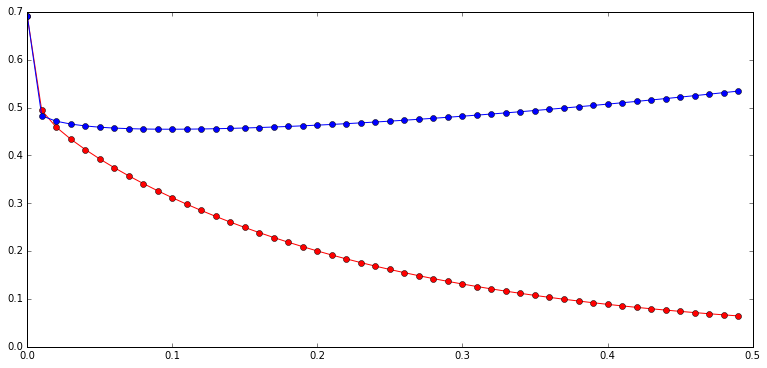

In [24]:
plt.figure(num=None, figsize=(13, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(arr_alpha, arr_log_loss_sgd_train_best_alpha, marker='o', color='r')
plt.plot(arr_alpha, arr_log_loss_sgd_test_best_alpha, marker='o', color='b')

ndarr_test = np.array(arr_log_loss_sgd_test_best_alpha)
(ndarr_test.argmin(), arr_alpha[ndarr_test.argmin()], arr_log_loss_sgd_test_best_alpha[ndarr_test.argmin()])


###### ADF : variance

In [25]:
#arr_var = list(np.linspace(.0001, 2., 50, endpoint=False)) # for titanic
arr_var = list(np.linspace(.0001, .2, 50, endpoint=False)) # for criteo

arr_log_loss_adf_train_best_var = [0]*len(arr_var)
arr_log_loss_adf_test_best_var = [0]*len(arr_var)

start_time = time.time()

for i in range(0,len(arr_var)):
    param, arr_y, arr_p, arr_log_loss_adf_train_best_var[i], arr_log_loss_adf_test_best_var[i] = adf_training(variance = arr_var[i]
             , D = 2**20
             , f_debug = False
             , f_step_validation = False
             , f_validation = True
            
             #, c_ds = ds_best_param_titanic
             , c_ds = ds_best_param_criteo
                                                                                                    
             #, c_fi = fi_titanic)
             , c_fi = fi_criteo)
    print('%s, i:%s, param:%s, log-loss(tr:%s, te:%s)' %(datetime.now(), i, arr_var[i]
                                                     , arr_log_loss_adf_train_best_var[i]
                                                     , arr_log_loss_adf_test_best_var[i]))
    
print("---Total execution time: %s seconds ---" % (time.time() - start_time))

2016-05-15 12:25:13.614000, i:0, param:0.0001, log-loss(tr:0.617901077649, te:0.563628771552)
2016-05-15 12:25:14.917000, i:1, param:0.004098, log-loss(tr:0.474281767633, te:0.467237422222)
2016-05-15 12:25:15.998000, i:2, param:0.008096, log-loss(tr:0.448740800087, te:0.460788749673)
2016-05-15 12:25:17.160000, i:3, param:0.012094, log-loss(tr:0.430093641179, te:0.45810323598)
2016-05-15 12:25:18.516000, i:4, param:0.016092, log-loss(tr:0.414742018098, te:0.456880443114)
2016-05-15 12:25:19.635000, i:5, param:0.02009, log-loss(tr:0.401432040148, te:0.456393242324)
2016-05-15 12:25:20.766000, i:6, param:0.024088, log-loss(tr:0.389554715597, te:0.456336134218)
2016-05-15 12:25:21.899000, i:7, param:0.028086, log-loss(tr:0.378760729095, te:0.456557256635)
2016-05-15 12:25:23.063000, i:8, param:0.032084, log-loss(tr:0.368827630076, te:0.456971977995)
2016-05-15 12:25:24.187000, i:9, param:0.036082, log-loss(tr:0.359603063556, te:0.457528999898)
2016-05-15 12:25:25.314000, i:10, param:0.04

(6, 0.024088000000000002, 0.45633613421798297)

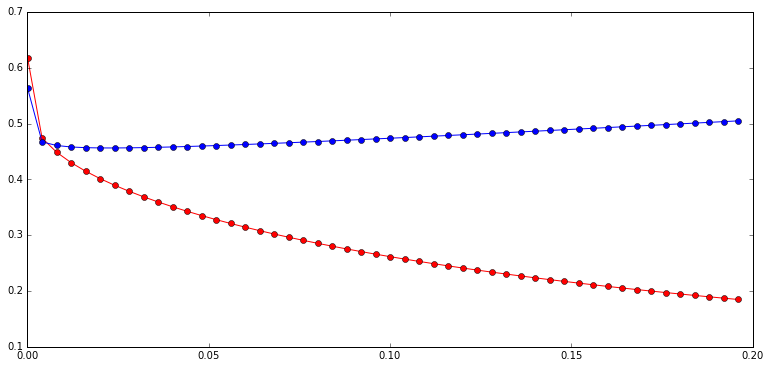

In [26]:
plt.figure(num=None, figsize=(13, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(arr_var, arr_log_loss_adf_train_best_var, marker='o', color= 'r')
plt.plot(arr_var, arr_log_loss_adf_test_best_var, marker='o', color= 'b')

ndarr_test = np.array(arr_log_loss_adf_test_best_var)
(ndarr_test.argmin(), arr_var[ndarr_test.argmin()], arr_log_loss_adf_test_best_var[ndarr_test.argmin()])

# Tracing log-loss as the number of sample grows(step_validation)

In [27]:
ds_step_vali_titanic = DataSize(np.round(800/50)      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 800        #train_start, train_size
                         , 801, 91)    #test_start, test_size

ds_step_vali_criteo = DataSize(np.round(1000/50)      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 1000        #train_start, train_size
                         , 1001, 100)    #test_start, test_size

ds_step_vali_criteo = DataSize(np.round(100000/50)      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 100000        #train_start, train_size
                         , 100001, 10000)    #test_start, test_size

ds_step_vali_titanic.display()
ds_step_vali_criteo.display()

num_metric_check_point: 16
num_status_check_point: 1
num_train_data_start  : 1
num_train_data_end    : 800
num_train_data_size   : 800
num_test_data_start   : 801
num_test_data_end     : 891
num_test_data_size    : 91
num_metric_check_point: 2000
num_status_check_point: 1
num_train_data_start  : 1
num_train_data_end    : 100000
num_train_data_size   : 100000
num_test_data_start   : 100001
num_test_data_end     : 110000
num_test_data_size    : 10000


###### SGD 

---Total execution time: 119.680999994 seconds ---


(49, 0.44698741592897445)

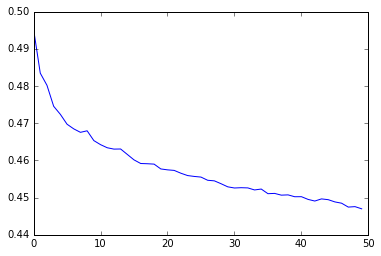

In [29]:
alpha = 0.92000539999999997 # best for titanic
alpha = 0.100008 # best for criteo

start_time = time.time()

TEST_DATA = 'C'
if(TEST_DATA == 'T'):  
    arr_log_loss_sgd_test = sgd_training(alpha = alpha
                                             , D = 2**20
                                             , f_debug = False
                                             , f_step_validation = True
                                             , f_validation = False
                                             , c_ds = ds_step_vali_titanic
                                             #, c_ds = ds_step_vali_criteo
                                             , c_fi = fi_titanic)
                                             #, c_fi = fi_criteo)
elif(TEST_DATA == 'C'):
    arr_log_loss_sgd_test = sgd_training(alpha = alpha
                                             , D = 2**20
                                             , f_debug = False
                                             , f_step_validation = True
                                             , f_validation = False
                                             #, c_ds = ds_step_vali_titanic
                                             , c_ds = ds_step_vali_criteo
                                             #, c_fi = fi_titanic)
                                             , c_fi = fi_criteo)
    
print("---Total execution time: %s seconds ---" % (time.time() - start_time))

plot_log_loss(arr_log_loss_sgd_test)

ndarr_log_loss_sgd_test = np.array(arr_log_loss_sgd_test)
(ndarr_log_loss_sgd_test.argmin(), arr_log_loss_sgd_test[ndarr_log_loss_sgd_test.argmin()])

###### ADF

---Total execution time: 129.832999945 seconds ---


(49, 0.4457743238543679)

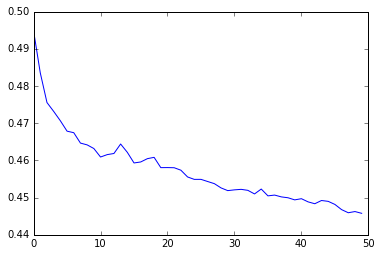

In [30]:
init_v = 0.52007399999999993 # best for titanic
#         0.024088000000000002
init_v = 0.034088000000000002 # best for criteo

start_time = time.time()

TEST_DATA = 'C'
if(TEST_DATA == 'T'):
    arr_log_loss_adf_test = adf_training(variance = init_v
                                             , D = 2**20
                                             , f_debug = False
                                             , f_step_validation = True
                                             , f_validation = False
                                             , c_ds = ds_step_vali_titanic
                                             #, c_ds = ds_step_vali_criteo
                                             , c_fi = fi_titanic)
                                             #, c_fi = fi_criteo)
elif(TEST_DATA == 'C'):
    arr_log_loss_adf_test = adf_training(variance = init_v
                                             , D = 2**20
                                             , f_debug = False
                                             , f_step_validation = True
                                             , f_validation = False
                                             #, c_ds = ds_step_vali_titanic
                                             , c_ds = ds_step_vali_criteo
                                             #, c_fi = fi_titanic)
                                             , c_fi = fi_criteo)

print("---Total execution time: %s seconds ---" % (time.time() - start_time))

plot_log_loss(arr_log_loss_adf_test)

ndarr_log_loss_adf_test = np.array(arr_log_loss_adf_test)
(ndarr_log_loss_adf_test.argmin(), arr_log_loss_adf_test[ndarr_log_loss_adf_test.argmin()])

중간에 튀어 오르는 부분은 특이치의 영향일 것이다.

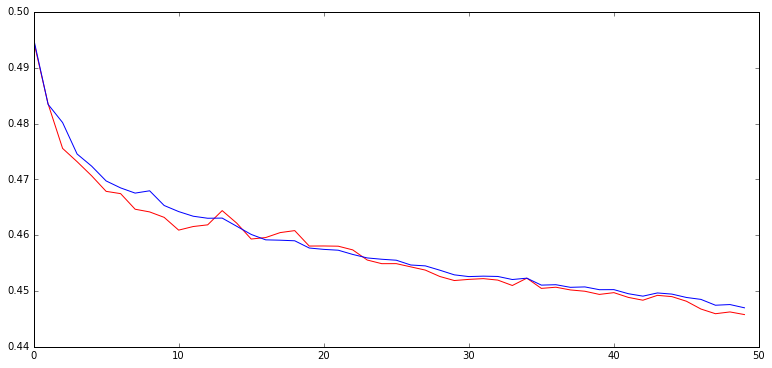

In [31]:
plot_log_loss_comparison((arr_log_loss_adf_test, arr_log_loss_sgd_test))

# ROC & AUC

In [32]:
ds_more_vali_titanic = DataSize(np.round(800/50)      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 800        #train_start, train_size
                         , 801, 91)    #test_start, test_size

ds_more_vali_criteo = DataSize(np.round(1000/50)      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 1000        #train_start, train_size
                         , 1001, 100)    #test_start, test_size


###### SGD

---Total execution time: 0.159999847412 seconds ---


(49, 0.44698741592897445)

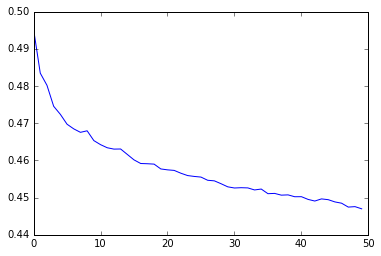

In [33]:
alpha = 0.92000539999999997 # best for titanic


start_time = time.time()

param_w, arr_sgd_y, arr_sgd_p, log_loss_sgd_train, log_loss_sgd_test = sgd_training(alpha = alpha
                                         , D = 2**20
                                         , f_debug = False
                                         , f_step_validation = False
                                         , f_validation = True
                                         , c_ds = ds_more_vali_titanic
                                         , c_fi = fi_titanic)

print("---Total execution time: %s seconds ---" % (time.time() - start_time))

plot_log_loss(arr_log_loss_sgd_test)

ndarr_log_loss_sgd_test = np.array(arr_log_loss_sgd_test)
(ndarr_log_loss_sgd_test.argmin(), arr_log_loss_sgd_test[ndarr_log_loss_sgd_test.argmin()])

###### ADF

---Total execution time: 0.358000040054 seconds ---


(49, 0.4457743238543679)

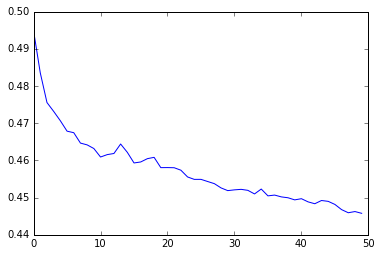

In [34]:
init_v = 0.52007399999999993 # best for titanic


start_time = time.time()
param_theta, arr_adf_y, arr_adf_p, log_loss_adf_train, log_loss_adf_test = adf_training(variance = init_v
                                         , D = 2**20
                                         , f_debug = False
                                         , f_step_validation = False
                                         , f_validation = True
                                         , c_ds = ds_more_vali_titanic
                                         , c_fi = fi_titanic)
print("---Total execution time: %s seconds ---" % (time.time() - start_time))

plot_log_loss(arr_log_loss_adf_test)

ndarr_log_loss_adf_test = np.array(arr_log_loss_adf_test)
(ndarr_log_loss_adf_test.argmin(), arr_log_loss_adf_test[ndarr_log_loss_adf_test.argmin()])

###### Comparison

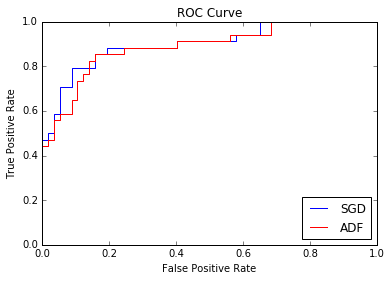

In [35]:
#fpr_sgd = dict()
#tpr_sgd = dict()
#roc_auc_sgd = dict()

fpr_sgd, tpr_sgd, _ = roc_curve(arr_sgd_y, arr_sgd_p)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd) #auc

fpr_adf, tpr_adf, _ = roc_curve(arr_adf_y, arr_adf_p)
roc_auc_adf = auc(fpr_adf, tpr_adf) #auc

plt.figure()
plt.plot(fpr_sgd, tpr_sgd, label='SGD', color='b')
plt.plot(fpr_adf, tpr_adf, label='ADF', color='r')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show() # or use command %matplotlib inline

In [36]:
(roc_auc_sgd, roc_auc_adf)

(0.90041279669762642, 0.88802889576883381)